# Imports

In [ ]:
import sys
path = '../src/models'
sys.path.append(path)

import venn_abers
import utilities
import importlib
importlib.reload(venn_abers)
importlib.reload(utilities)

from venn_abers import VennAbersCalibrator
from utilities import calculate_ece


import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, brier_score_loss, fbeta_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Extracts

In [10]:
X_train = joblib.load('../data/processed/X_train.joblib')
y_train = joblib.load('../data/processed/y_train.joblib')

X_train_resampled = joblib.load('../data/processed/X_train_resampled.joblib')
y_train_resampled = joblib.load('../data/processed/y_train_resampled.joblib')

X_test_ = joblib.load('../data/processed/X_test_.joblib')
y_test_ = joblib.load('../data/processed/y_test_.joblib')

X_cal = joblib.load('../data/processed/X_cal.joblib')
X_test = joblib.load('../data/processed/X_test.joblib')

y_cal = joblib.load('../data/processed/y_cal.joblib')
y_test = joblib.load('../data/processed/y_test.joblib')


train_data = joblib.load('../data/processed/train_data_lgb.joblib')
test_data_ = joblib.load('../data/processed/test_data_lgb_test_.joblib')
cal_data  = joblib.load('../data/processed/cal_data_lgb.joblib')
test_data = joblib.load('../data/processed/test_data_lgb.joblib')

best_model = joblib.load('../models/best_model_lgb.joblib')

y_cal_proba = joblib.load('../data/processed/y_cal_proba.joblib')
y_cal_pred = joblib.load('../data/processed/y_cal_pred.joblib')

# Calibration

**Recall (Sensitividade)**
```
Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)
        = TP / (TP + FN)
```

**Interpretação no Churn:**
- "De todos os clientes que **realmente iriam embora**, quantos % o modelo **conseguiu identificar**?"
- **Recall alto** = Poucos clientes escapam sem serem detectados

---

**Precision (Precisão)**
```
Precision = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)
          = TP / (TP + FP)
```

**Interpretação no Churn:**
- "De todos os clientes que o modelo **classificou como churn**, quantos % **realmente iriam embora**?"
- **Precision alto** = Poucas ações de retenção desperdiçadas

---

**F1-Score**
```
F1-Score = 2 × (Precision × Recall) / (Precision + Recall)
```

**Interpretação no Churn:**
- **Média harmônica** entre Precision e Recall
- **Balanceia** os dois objetivos (não deixar clientes escaparem vs não desperdiçar recursos)

---

**Aplicação no Negócio de Churn:**

**Cenário com Threshold 0.5:**
```
Matriz de Confusão:
[[TN=900, FP=400],   → 400 ações de retenção desperdiçadas
 [FN=100, TP=400]]    → 100 clientes perdidos sem detecção

Recall = 400 / (400 + 100) = 400/500 = 80%
Precision = 400 / (400 + 400) = 400/800 = 50%
F1-Score = 2 × (0.5 × 0.8) / (0.5 + 0.8) = 0.615
```

**Se baixarmos o Threshold para 0.3:**
```
Matriz de Confusão:
[[TN=700, FP=600],   → 600 ações desperdiçadas (↑)
 [FN=50, TP=450]]     → 50 clientes perdidos (↓)

Recall = 450 / (450 + 50) = 450/500 = 90%  (↑)
Precision = 450 / (450 + 600) = 450/1050 = 43% (↓)
F1-Score = 2 × (0.43 × 0.9) / (0.43 + 0.9) = 0.582 (↓)
```

---

**Trade-off no Churn:**

| Métrica | Foco | Custo de Erro |
|---------|------|---------------|
| **Recall** | **Não perder clientes** | Alto: Cliente vai embora sem detecção |
| **Precision** | **Não desperdiçar recursos** | Baixo: Ação de retenção desnecessária |
| **F1-Score** | **Balanceamento** | Média dos dois custos |

**Decisão Estratégica:**

**Se custo de perder cliente > custo de ação de retenção:**
- **Priorizar RECALL** (threshold mais baixo)
- "Melhor oferecer desconto para 10 clientes fiéis do que perder 1 cliente"

**Se custo de ação de retenção for muito alto:**
- **Priorizar PRECISION** (threshold mais alto) 
- "Só ofereço desconto quando tenho alta certeza"

**Para Churn, geralmente Recall é mais importante!**

In [11]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

In [12]:
y_test_proba = best_model.predict_proba(X_test)

calibrator = VennAbersCalibrator()
calibrator.fit(y_cal_proba, y_cal)
p_calibrated_proba = calibrator.predict_proba(y_test_proba)
p_calibrated_pred = (p_calibrated_proba > 0.5).astype(int)

joblib.dump(calibrator, '../models/venn_abers_calibrator.joblib')


['../models/venn_abers_calibrator.joblib']

=== COMPARAÇÃO: SEM vs COM CALIBRAÇÃO ===

Melhor threshold (otimizado em calibração): 0.300

=== AUC Score ===
Teste SEM calibração:  0.8248
Teste COM calibração:  0.8251

=== Classification Report (SEM calibração, threshold=0.5) ===
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       240
           1       0.43      0.79      0.56        77

    accuracy                           0.70       317
   macro avg       0.67      0.73      0.66       317
weighted avg       0.79      0.70      0.72       317


=== Classification Report (COM calibração, threshold=0.5) ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       240
           1       0.60      0.47      0.53        77

    accuracy                           0.79       317
   macro avg       0.72      0.68      0.70       317
weighted avg       0.78      0.79      0.79       317


=== Classification Report (COM calibração, thre

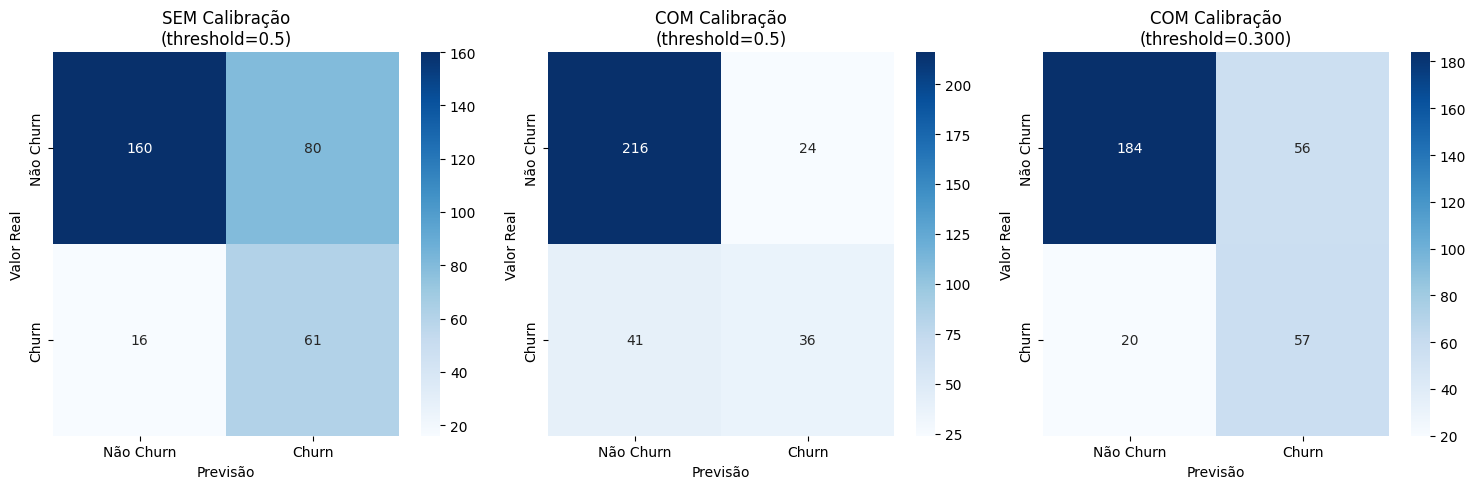

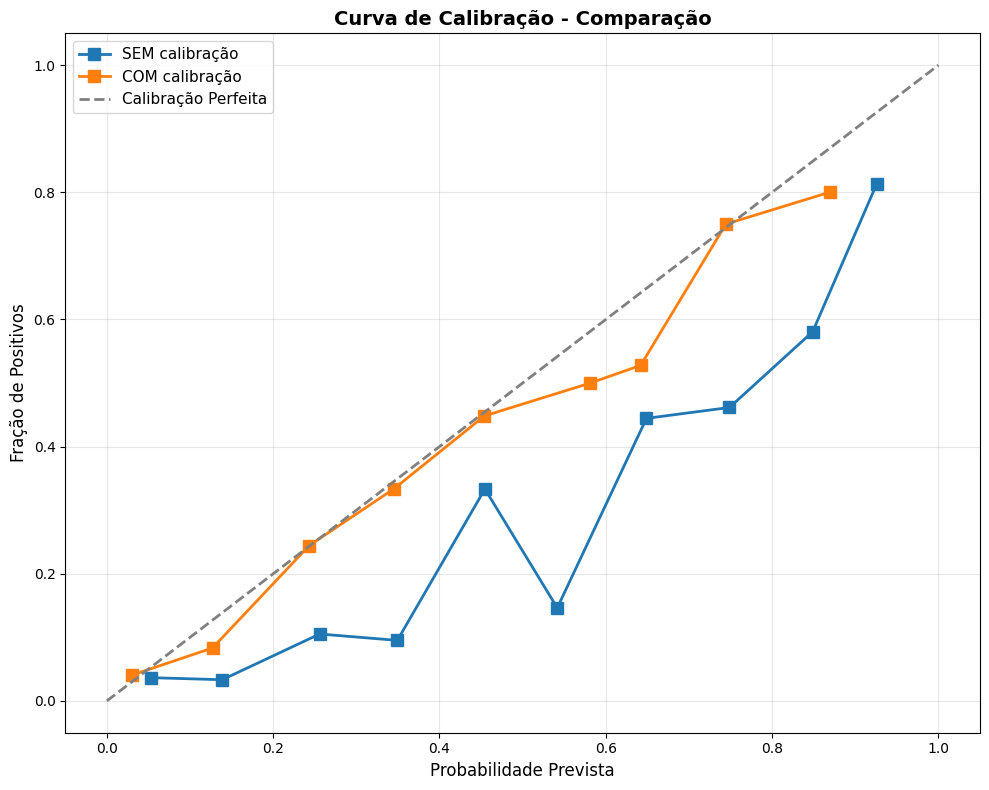


=== Métricas de Calibração ===
ECE SEM:    0.1734
ECE COM:    0.0300 (melhora: 82.7%)

Brier SEM:  0.1763
Brier COM:  0.1366 (melhora: 22.5%)


In [ ]:
# Obtém probabilidades
y_test_proba = best_model.predict_proba(X_test)
y_cal_proba = best_model.predict_proba(X_cal)

# Calibra as probabilidades no conjunto de teste
calibrator = VennAbersCalibrator()
calibrator.fit(y_cal_proba, y_cal)
p_calibrated_proba = calibrator.predict_proba(y_test_proba)

# OTIMIZA THRESHOLD NO CONJUNTO DE CALIBRAÇÃO 
p_cal_calibrated = calibrator.predict_proba(y_cal_proba)
thresholds = np.linspace(0.3, 0.7, 50)
# f1_scores = [f1_score(y_cal, (p_cal_calibrated[:, 1] > t).astype(int)) for t in thresholds]
# best_threshold = thresholds[np.argmax(f1_scores)]

# beta > 1: favorece recall
# beta < 1: favorece precision
beta = 2  # Recall é 2x mais importante

fbeta_scores = [fbeta_score(y_cal, (p_cal_calibrated[:, 1] > t).astype(int), beta=beta) 
                for t in thresholds]
best_threshold = thresholds[np.argmax(fbeta_scores)]

# Aplica threshold no teste
y_test_pred = best_model.predict(X_test)
p_calibrated_pred = (p_calibrated_proba[:, 1] > 0.5).astype(int)
p_calibrated_pred_opt = (p_calibrated_proba[:, 1] > best_threshold).astype(int)

print("=== COMPARAÇÃO: SEM vs COM CALIBRAÇÃO ===\n")
print(f"Melhor threshold (otimizado em calibração): {best_threshold:.3f}\n")

# AUC
print("=== AUC Score ===")
print(f"Teste SEM calibração:  {roc_auc_score(y_test, y_test_proba[:, 1]):.4f}")
print(f"Teste COM calibração:  {roc_auc_score(y_test, p_calibrated_proba[:, 1]):.4f}")

# Classification Reports
print("\n=== Classification Report (SEM calibração, threshold=0.5) ===")
print(classification_report(y_test, y_test_pred))

print("\n=== Classification Report (COM calibração, threshold=0.5) ===")
print(classification_report(y_test, p_calibrated_pred))

print(f"\n=== Classification Report (COM calibração, threshold={best_threshold:.3f}) ===")
print(classification_report(y_test, p_calibrated_pred_opt))

# Matrizes de Confusão
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

cm1 = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
ax1.set_title('SEM Calibração\n(threshold=0.5)')
ax1.set_ylabel('Valor Real')
ax1.set_xlabel('Previsão')

cm2 = confusion_matrix(y_test, p_calibrated_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
ax2.set_title('COM Calibração\n(threshold=0.5)')
ax2.set_ylabel('Valor Real')
ax2.set_xlabel('Previsão')

cm3 = confusion_matrix(y_test, p_calibrated_pred_opt)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
ax3.set_title(f'COM Calibração\n(threshold={best_threshold:.3f})')
ax3.set_ylabel('Valor Real')
ax3.set_xlabel('Previsão')

plt.tight_layout()
plt.show()

# Curva de Calibração
plt.figure(figsize=(10, 8))
prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_test_proba[:, 1], n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, p_calibrated_proba[:, 1], n_bins=10)

plt.plot(prob_pred_raw, prob_true_raw, 's-', label='SEM calibração', linewidth=2, markersize=8)
plt.plot(prob_pred_cal, prob_true_cal, 's-', label='COM calibração', linewidth=2, markersize=8)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Calibração Perfeita', linewidth=2)

plt.xlabel('Probabilidade Prevista', fontsize=12)
plt.ylabel('Fração de Positivos', fontsize=12)
plt.title('Curva de Calibração - Comparação', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ECE e Brier Score
ece_raw = calculate_ece(y_test, y_test_proba[:, 1])
ece_cal = calculate_ece(y_test, p_calibrated_proba[:, 1])
brier_raw = brier_score_loss(y_test, y_test_proba[:, 1])
brier_cal = brier_score_loss(y_test, p_calibrated_proba[:, 1])

print(f"\n=== Métricas de Calibração ===")
print(f"ECE SEM:    {ece_raw:.4f}")
print(f"ECE COM:    {ece_cal:.4f} (melhora: {(1-ece_cal/ece_raw)*100:.1f}%)")
print(f"\nBrier SEM:  {brier_raw:.4f}")
print(f"Brier COM:  {brier_cal:.4f} (melhora: {(1-brier_cal/brier_raw)*100:.1f}%)")